$$\textrm{Joaquin Peñuela Parra}$$
$$\textrm{University of Los Andes}$$
$$\textrm{High Energy Physics Group: Phenomenology of Particles}$$

This code was written to be running in Docker. If you do not have a Docker inside hep-server2 please refer to: https://github.com/Phenomenology-group-uniandes/Tutoriales_Generales

$\textbf{Preliminaries}$ 

The libraries used here are:

In [1]:
import os, sys
sys.path.append(os.path.dirname(os.path.dirname(os.getcwd())))

In [2]:
from Uniandes_Framework.ml_tools.xgb_classifier import XGB_Classifier
from Uniandes_Framework.ml_tools import tools
from Uniandes_Framework.stats_helper import power_test
from Uniandes_Framework.delphes_reader import root_analysis

import numpy as np

Welcome to JupyROOT 6.22/06


Until now, we created .csv files. Now we will use it to train machine learning models.

**1. Define dictionaries with the paths of .csv files:**

We must create a separate dictionary for signal and background:

In [3]:
Datasets_signal = {'z': ['Data_z.csv']}
Datasets_bkg = {'stop': ['Data_stop.csv'], 'ttbar': ['Data_ttbar.csv'], 'ww': ['Data_ww.csv']}

**2. Create Machine Learning model:**

We can create a gradient boosting model (XGB). To do this, we need to define some parameters, there are a lot of options (see the documentation at https://xgboost.readthedocs.io/en/stable/). We must define a dictionary[str, list] that contains a list of options for each parameter using the name of the parameter as the key:

In [4]:
parameters={
    "n_estimators":[
        100,
        125, 
        200,
        500,
    ],
    "max_depth":[
        3,
        5,
        7,
    ],
    "learning_rate":[
        0.1, 
        0.2
    ]
}

Uniandes_Framework will use **sklearn.model_selection.GridSearchCV()** to find the best parameters using a “fit” and a “score” method (see the documentation at https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.GridSearchCV.html).

In [5]:
XGB_model = XGB_Classifier(ncpu = 12,
                           cv =10, 
                           parameters = parameters,
                           signal_dictionary = Datasets_signal,
                           bkg_dictionary = Datasets_bkg)

At this point, Uniandes_Framework has read the .csv and created the datasets that will be used to train and test the model. We can continue to train the model and save it in a .joblib. However, to understand better what is doing Uniandes_Framework, let us print and explore some of XGB_model's attributes.

For example:

In [6]:
XGB_model.bkg_data_balanced

,pT_{Z}(GeV),#eta_{Z},#phi_{Z},Energy_{Z}(GeV),Mass_{Z}(GeV),pT_{#mu_{1}}(GeV),#eta_{#mu_{1}},#phi_{#mu_{1}},Energy_{#mu_{1}}(GeV),Mass_{#mu_{1}}(GeV)),...,#Delta{#eta}_{#mu_{1}#mu_{2}},#Delta{#phi}_{#mu_{1}#mu_{2}},#Delta{pT}_{#mu_{1}#mu_{2}}(GeV),#Delta{#vec{pT}}_{#mu_{1}#mu_{2}}(GeV),#Delta{#vec{p}}_{#mu_{1}#mu_{2}}(GeV),pT_{#mu_{2}}(GeV),#eta_{#mu_{2}},#phi_{#mu_{2}},Energy_{#mu_{2}}(GeV),Mass_{#mu_{2}}(GeV))
0,52.492508,-0.208437,1.687759,91.938199,74.670689,30.069496,-1.116152,2.119674,50.826902,0.105658,...,-2.042073,0.895410,1.914612,25.264220,75.299801,28.154884,0.925920,1.224264,41.111296,0.105658
1,27.916926,-2.361309,-0.368486,168.977919,79.057719,35.102104,-1.992703,0.670389,131.135561,0.105658,...,-1.391310,2.287046,3.204178,60.991115,122.285323,31.897926,-0.601393,-1.616657,37.842357,0.105658
2,56.077131,1.236584,-0.603198,108.239003,27.444990,41.643181,1.296340,-0.335738,81.816905,0.105658,...,0.465438,0.872485,22.293886,32.748356,61.820445,19.349295,0.830902,-1.208223,26.422098,0.105658
3,24.152098,-0.218682,0.481981,90.524036,87.080044,50.821205,-0.101757,1.337116,51.084657,0.105658,...,-0.098120,2.661178,11.382229,87.710499,87.855005,39.438976,-0.003638,-1.324061,39.439379,0.105658
4,59.141016,-0.804156,2.507032,96.004324,54.090322,41.114857,-0.231955,1.964508,42.226007,0.105658,...,0.877474,-1.268150,9.126596,43.928359,55.309802,31.988260,-1.109428,-3.050527,53.778317,0.105658
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
325,93.821693,2.147794,-2.375336,414.600427,77.397246,87.564911,2.160001,-2.591273,384.693140,0.105658,...,1.236096,-1.370657,67.053011,85.873123,363.129855,20.511900,0.923904,-1.220615,29.907286,0.105658
326,29.714186,1.964346,-0.025162,118.275049,48.176940,31.315256,1.586111,0.765187,79.688528,0.105658,...,0.508429,2.028783,7.774376,46.762204,63.327308,23.540880,1.077682,-1.263595,38.586521,0.105658
327,55.678390,-1.090557,-1.680432,111.794284,63.219473,32.953678,-1.577328,-2.083315,83.183848,0.105658,...,-1.678520,-0.874028,4.489296,26.310621,83.515953,28.464382,0.101192,-1.209287,28.610436,0.105658
328,84.951462,2.031260,2.917959,332.244550,43.435121,66.194633,1.954935,-3.067776,238.467236,0.105658,...,0.115903,1.027794,37.113787,56.904301,151.068656,29.080847,1.839032,2.187615,93.777313,0.105658


XGB_model.bkg_data_balanced is a Dataset that contains 110 rows from each background ('Data_stop.csv', 'Data_ttbar.csv', 'Data_ww.csv'). Why 110? because this is the maximum number of rows that contains the file with minus rows. So, Uniandes_Framework choose randomly 110 rows for each background and create a balanced dataset of background.

Regarding XGB_model.signal_data_balanced has 1555 rows, because there is only one .csv file of signal ('Data_z.csv'). If there is more than one file, Uniandes_Framework will do the same that did for Background in this tutorial.

Now Uniandes_Framework adds one column with 1 to XGB_model.signal_data_balanced and one column with 0 to XGB_model.bkg_data_balanced. Then we have 1555 rows with the label "1" and 330 rows with the label "0". It can not be used to train the model. So Uniandes_Framework balance the background and the signal in one dataset, i.e. Uniandes Framework chooses randomly 330 rows or each one. At this point, we have just one dataframe with 660 rows and one column with the labels (0 and 1) that contains all the background and signal.

Then, Uniandes Framework recognizes the column with labels as the output (XGB_model.Y), and the dataframe without that column as the input (XGB_model.X):

In [7]:
XGB_model.X

,pT_{Z}(GeV),#eta_{Z},#phi_{Z},Energy_{Z}(GeV),Mass_{Z}(GeV),pT_{#mu_{1}}(GeV),#eta_{#mu_{1}},#phi_{#mu_{1}},Energy_{#mu_{1}}(GeV),Mass_{#mu_{1}}(GeV)),...,#Delta{#eta}_{#mu_{1}#mu_{2}},#Delta{#phi}_{#mu_{1}#mu_{2}},#Delta{pT}_{#mu_{1}#mu_{2}}(GeV),#Delta{#vec{pT}}_{#mu_{1}#mu_{2}}(GeV),#Delta{#vec{p}}_{#mu_{1}#mu_{2}}(GeV),pT_{#mu_{2}}(GeV),#eta_{#mu_{2}},#phi_{#mu_{2}},Energy_{#mu_{2}}(GeV),Mass_{#mu_{2}}(GeV))
0,53.881120,-1.945482,0.407473,255.457843,168.103709,96.848991,-0.417855,0.610746,105.427818,0.105658,...,1.446906,2.899649,51.449471,141.345365,173.920008,45.399521,-1.864760,-2.288903,150.030025,0.105658
1,223.534452,-1.366073,-2.366762,475.833594,93.124617,202.462036,-1.340960,-2.518108,413.458603,0.105658,...,-0.276527,-1.068386,164.007889,187.006801,363.224245,38.454147,-1.064433,-1.449722,62.374991,0.105658
2,24.016807,-0.217709,2.218259,67.406836,62.762256,31.805340,0.537418,2.914750,36.510080,0.105658,...,1.512235,2.285958,11.397718,47.741955,63.012424,20.407621,-0.974818,0.628792,30.896756,0.105658
3,47.096552,-2.482781,-1.840791,297.593830,89.089476,69.888855,-1.605565,-1.540248,181.062791,0.105658,...,0.479065,2.631210,41.348207,95.812087,110.005623,28.540648,-2.084630,2.111727,116.531039,0.105658
4,22.547913,1.243657,1.255421,96.771266,87.011537,28.928854,1.485748,1.845497,67.181586,0.105658,...,2.698738,2.253115,12.763420,41.085171,94.784567,16.165434,-1.212990,-0.407618,29.589680,0.105658
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
655,165.260788,1.691018,2.802231,472.215152,90.297855,115.992157,1.219367,2.733759,213.452404,0.105658,...,-1.104700,-0.227312,65.820126,68.056582,101.028141,50.172031,2.324067,2.961072,258.762748,0.105658
656,80.004624,-0.707558,-2.836377,136.457571,91.889683,64.760216,-0.220197,2.742075,66.336654,0.105658,...,0.592995,-1.644250,12.790638,85.957578,91.967331,51.969578,-0.813191,-1.896860,70.120917,0.105658
657,63.405540,1.451997,-3.104856,153.403135,55.928571,42.331047,0.602547,-3.041384,50.250893,0.105658,...,-1.655854,0.189690,21.001638,21.759135,76.983849,21.329409,2.258401,3.052111,103.152242,0.105658
658,38.517571,-2.958824,-2.706237,402.163372,152.280197,86.712944,-2.024720,-2.824719,334.105797,0.105658,...,-1.159654,-3.047925,38.034142,135.255010,306.546685,48.678802,-0.865066,0.223206,68.057575,0.105658


In [8]:
XGB_model.Y

0      0.0
1      1.0
2      0.0
3      1.0
4      0.0
      ... 
655    1.0
656    1.0
657    0.0
658    0.0
659    0.0
Name: Label, Length: 660, dtype: float64

Finally, Uniandes_Framework defines four datasets:

- X and Y for Training using 80% of data (528 rows):

In [9]:
XGB_model.trainPred

,pT_{Z}(GeV),#eta_{Z},#phi_{Z},Energy_{Z}(GeV),Mass_{Z}(GeV),pT_{#mu_{1}}(GeV),#eta_{#mu_{1}},#phi_{#mu_{1}},Energy_{#mu_{1}}(GeV),Mass_{#mu_{1}}(GeV)),...,#Delta{#eta}_{#mu_{1}#mu_{2}},#Delta{#phi}_{#mu_{1}#mu_{2}},#Delta{pT}_{#mu_{1}#mu_{2}}(GeV),#Delta{#vec{pT}}_{#mu_{1}#mu_{2}}(GeV),#Delta{#vec{p}}_{#mu_{1}#mu_{2}}(GeV),pT_{#mu_{2}}(GeV),#eta_{#mu_{2}},#phi_{#mu_{2}},Energy_{#mu_{2}}(GeV),Mass_{#mu_{2}}(GeV))
156,4.237586,4.847163,-1.970855,284.424791,89.714221,44.738281,1.514549,-1.700266,106.639901,0.105658,...,-0.640318,3.113738,4.067619,85.400679,114.499810,40.670662,2.154867,1.469181,177.784891,0.105658
12,53.971032,1.209014,-3.036043,201.007452,175.240905,115.135048,0.470148,2.866747,128.095899,0.105658,...,0.093949,-2.842645,47.095306,181.268031,183.724365,68.039742,0.376199,-0.573793,72.911553,0.105658
584,28.635736,-0.147076,-0.686560,71.399387,65.268683,44.572201,-0.185735,-0.113267,45.343351,0.105658,...,-0.344387,2.493553,18.840891,66.914553,68.058481,25.731310,0.158652,-2.606819,26.056037,0.105658
338,105.575239,2.257378,2.989092,519.006481,95.914247,96.575569,1.950411,2.538234,346.406554,0.105658,...,-0.046160,-1.604479,50.546265,108.374092,198.515092,46.029305,1.996571,-2.140472,172.599927,0.105658
550,24.156955,-0.622452,-2.502850,95.840195,91.350620,47.791992,-0.339264,-1.294372,50.569011,0.105658,...,-0.350318,2.619155,2.523697,89.905660,91.503869,45.268295,0.011054,2.369659,45.271184,0.105658
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
93,75.327023,-0.923246,-1.479017,141.536220,89.339361,66.923851,-0.873574,-2.118188,94.125581,0.105658,...,-0.576890,-1.713736,21.526024,86.054452,100.815488,45.397827,-0.296684,-0.404452,47.410638,0.105658
484,78.800111,1.178443,-0.531769,162.855505,82.947298,49.433617,0.240292,-1.012427,50.867765,0.105658,...,-1.402186,-1.059587,7.658566,46.564120,103.033300,41.775051,1.642479,0.047160,111.987740,0.105658
476,53.446445,2.758798,-3.055355,444.659112,135.817889,70.145447,2.227635,-2.067037,329.181301,0.105658,...,0.963774,2.310682,9.711487,119.535651,253.210655,60.433960,1.263860,1.905466,115.477811,0.105658
566,33.662285,1.983887,1.467840,196.140695,151.402636,75.681862,0.345261,2.602359,80.237759,0.105658,...,-0.770087,2.680806,7.068436,140.491792,155.546515,68.613426,1.115348,-0.078447,115.902936,0.105658


In [10]:
XGB_model.trainLab

156    1.0
12     0.0
584    0.0
338    1.0
550    1.0
      ... 
93     1.0
484    0.0
476    0.0
566    0.0
558    0.0
Name: Label, Length: 528, dtype: float64

- X and Y for Testing using 20% of data (132 rows):

In [11]:
XGB_model.testPred

,pT_{Z}(GeV),#eta_{Z},#phi_{Z},Energy_{Z}(GeV),Mass_{Z}(GeV),pT_{#mu_{1}}(GeV),#eta_{#mu_{1}},#phi_{#mu_{1}},Energy_{#mu_{1}}(GeV),Mass_{#mu_{1}}(GeV)),...,#Delta{#eta}_{#mu_{1}#mu_{2}},#Delta{#phi}_{#mu_{1}#mu_{2}},#Delta{pT}_{#mu_{1}#mu_{2}}(GeV),#Delta{#vec{pT}}_{#mu_{1}#mu_{2}}(GeV),#Delta{#vec{p}}_{#mu_{1}#mu_{2}}(GeV),pT_{#mu_{2}}(GeV),#eta_{#mu_{2}},#phi_{#mu_{2}},Energy_{#mu_{2}}(GeV),Mass_{#mu_{2}}(GeV))
87,68.089847,2.013784,0.346052,313.428584,175.634570,119.456573,0.935936,0.783108,175.709792,0.105658,...,-0.454760,2.678816,54.899147,179.551779,179.696337,64.557426,1.390697,-1.895709,137.718792,0.105658
20,51.595065,1.232104,2.430625,131.987635,90.612051,63.093388,1.152159,2.136688,109.813239,0.105658,...,1.580560,-2.313058,42.809235,78.245729,126.059772,20.284153,-0.428401,-1.833439,22.174396,0.105658
133,68.567683,0.907817,0.828500,133.910630,90.373265,79.452301,0.281584,1.000593,82.623097,0.105658,...,-1.504967,2.362777,62.736404,92.101311,95.651450,16.715897,1.786551,-1.362183,51.287533,0.105658
438,49.002662,1.660556,-3.140497,140.471867,43.435286,36.487545,1.581161,-2.551393,92.429107,0.105658,...,0.426973,1.415763,8.930372,42.192612,62.102554,27.557173,1.154188,2.316029,48.042759,0.105658
129,40.436966,-2.136195,-2.690145,194.913757,88.662509,51.295673,-0.821971,2.977393,69.622237,0.105658,...,1.297789,-2.235044,21.638075,73.392713,104.690329,29.657598,-2.119760,-1.070748,125.291520,0.105658
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
46,53.653546,0.826989,1.545638,143.340124,123.317069,72.635315,0.375054,0.564058,77.804181,0.105658,...,0.030646,-2.335760,10.803017,123.772134,123.925641,61.832298,0.344407,2.899817,65.535942,0.105658
565,33.258750,-2.194826,0.239133,177.118189,92.315410,42.421974,-2.005363,0.557567,160.427207,0.105658,...,-2.471604,2.376081,27.394476,54.265594,170.827962,15.027498,0.466241,-1.818514,16.690982,0.105658
3,47.096552,-2.482781,-1.840791,297.593830,89.089476,69.888855,-1.605565,-1.540248,181.062791,0.105658,...,0.479065,2.631210,41.348207,95.812087,110.005623,28.540648,-2.084630,2.111727,116.531039,0.105658
182,61.064529,-2.888388,-0.416822,558.930556,98.452989,88.192680,-2.284935,-0.355060,437.737012,0.105658,...,-0.121865,3.004124,60.688629,115.498774,331.500698,27.504051,-2.163070,2.924001,121.193545,0.105658


In [12]:
XGB_model.testLab

87     0.0
20     1.0
133    0.0
438    0.0
129    1.0
      ... 
46     0.0
565    1.0
3      1.0
182    0.0
8      1.0
Name: Label, Length: 132, dtype: float64

All of this was explained to understand better what is doing Uniandes_Framework when we define XGB_model:

In [13]:
XGB_model = XGB_Classifier(ncpu = 12,
                       cv =10, 
                       parameters = parameters,
                       signal_dictionary = Datasets_signal,
                       bkg_dictionary = Datasets_bkg)

As we have seen during this tutorial, .csv files have 21 columns. Sometimes we have datasets with more than 50 kinematic variables, and we have to train a lot of models. The time that Machine learning model takes during its training is bigger according to the number of columns (kinematic variables): So, it is useful to have a function that allows us to know the most important features between all the columns. To do this, we can use the function **get_important_features()**

In [14]:
XGB_model.get_important_features()

Fitting 10 folds for each of 24 candidates, totalling 240 fits
For the Gradient_Boosting model
the Best Parameters are {'learning_rate': 0.1, 'max_depth': 3, 'n_estimators': 100}


[['Mass_{Z}(GeV)', 0.41236454],
 ['#Delta{R}_{#mu_{1}#mu_{2}}', 0.05056975],
 ['pT_{#mu_{2}}(GeV)', 0.043977182],
 ['#Delta{#vec{p}}_{#mu_{1}#mu_{2}}(GeV)', 0.042442627],
 ['#eta_{Z}', 0.04148595],
 ['pT_{Z}(GeV)', 0.0409424],
 ['#Delta{#vec{pT}}_{#mu_{1}#mu_{2}}(GeV)', 0.040044274],
 ['pT_{#mu_{1}}(GeV)', 0.038403388],
 ['Energy_{#mu_{2}}(GeV)', 0.03631582],
 ['#phi_{#mu_{1}}', 0.03441424],
 ['#Delta{pT}_{#mu_{1}#mu_{2}}(GeV)', 0.03441025],
 ['#Delta{#phi}_{#mu_{1}#mu_{2}}', 0.03270454],
 ['#eta_{#mu_{2}}', 0.027307663],
 ['Energy_{#mu_{1}}(GeV)', 0.024086988],
 ['#phi_{Z}', 0.023567608],
 ['#eta_{#mu_{1}}', 0.021666316],
 ['Energy_{Z}(GeV)', 0.020615365],
 ['#Delta{#eta}_{#mu_{1}#mu_{2}}', 0.018338775],
 ['#phi_{#mu_{2}}', 0.016342334],
 ['Mass_{#mu_{1}}(GeV))', 0.0],
 ['Mass_{#mu_{2}}(GeV))', 0.0]]

This function returns a float that corresponds to the importance that each column plays when the model is training. However, it is possible that some of these variables could be correlated between them. For example, if 'Mass_{Z}(GeV)' is very correlated to '#Delta{#vec{p}}_{#mu_{1}#mu_{2}}(GeV)', then of course that both will be in the top. Then, it is necessary a function that analyzes the correlation between the columns and their importance at the same time. Before using this function, let us plot the correlation between the columns in a dataframe. To do this, we can use the function **tools.dataframe_correlation()** and put the DataFrame that we want to analyze as the parameter. This function returns a matrix where each entry is the correlation between the column and the row:

In [15]:
Correlation_Matrix = tools.dataframe_correlation(XGB_model.X)

In [16]:
Correlation_Matrix

,pT_{Z}(GeV),#eta_{Z},#phi_{Z},Energy_{Z}(GeV),Mass_{Z}(GeV),pT_{#mu_{1}}(GeV),#eta_{#mu_{1}},#phi_{#mu_{1}},Energy_{#mu_{1}}(GeV),Mass_{#mu_{1}}(GeV)),...,#Delta{#eta}_{#mu_{1}#mu_{2}},#Delta{#phi}_{#mu_{1}#mu_{2}},#Delta{pT}_{#mu_{1}#mu_{2}}(GeV),#Delta{#vec{pT}}_{#mu_{1}#mu_{2}}(GeV),#Delta{#vec{p}}_{#mu_{1}#mu_{2}}(GeV),pT_{#mu_{2}}(GeV),#eta_{#mu_{2}},#phi_{#mu_{2}},Energy_{#mu_{2}}(GeV),Mass_{#mu_{2}}(GeV))
pT_{Z}(GeV),1.000000,0.033456,-0.033691,0.472893,0.071655,0.845173,0.005484,-0.084339,0.476405,0.128494,...,0.003752,0.000246,0.722306,0.384151,0.325282,0.473906,0.001511,-0.000169,0.238242,-0.186300
#eta_{Z},0.033456,1.000000,0.105148,0.055349,0.040136,0.035376,0.867991,0.031986,0.036205,-0.020535,...,0.066204,-0.015071,0.030206,0.034322,0.045079,0.019880,0.751969,-0.039702,0.058716,-0.033540
#phi_{Z},-0.033691,0.105148,1.000000,-0.011050,-0.074507,-0.053364,0.098897,0.656124,-0.020940,-0.047194,...,0.049742,-0.065800,-0.047032,-0.052452,-0.062705,-0.027601,0.044676,-0.056068,0.009898,0.011515
Energy_{Z}(GeV),0.472893,0.055349,-0.011050,1.000000,0.438020,0.587251,0.052038,-0.046031,0.888712,0.066426,...,0.048321,-0.009003,0.383952,0.537907,0.757164,0.521338,0.001989,0.106317,0.690976,-0.348491
Mass_{Z}(GeV),0.071655,0.040136,-0.074507,0.438020,1.000000,0.422149,0.081887,-0.043381,0.274950,-0.030502,...,0.107462,-0.062888,0.166974,0.712608,0.668324,0.552335,-0.027402,0.073721,0.482917,-0.292776
pT_{#mu_{1}}(GeV),0.845173,0.035376,-0.053364,0.587251,0.422149,1.000000,0.036438,-0.079754,0.590180,0.116775,...,0.055774,-0.008410,0.859264,0.801507,0.576528,0.553166,-0.019923,0.021156,0.298112,-0.297312
#eta_{#mu_{1}},0.005484,0.867991,0.098897,0.052038,0.081887,0.036438,1.000000,0.018266,0.035650,-0.029430,...,0.453342,-0.002127,0.020316,0.068790,0.070291,0.038061,0.499962,-0.008935,0.052665,-0.028114
#phi_{#mu_{1}},-0.084339,0.031986,0.656124,-0.046031,-0.043381,-0.079754,0.018266,1.000000,-0.050273,-0.062538,...,0.029883,-0.019852,-0.072563,-0.051305,-0.048286,-0.037548,-0.011857,-0.232366,-0.017042,-0.016883
Energy_{#mu_{1}}(GeV),0.476405,0.036205,-0.020940,0.888712,0.274950,0.590180,0.035650,-0.050273,1.000000,0.095061,...,0.052975,-0.007779,0.534491,0.491058,0.808780,0.281892,-0.017946,0.073874,0.282663,-0.196147
Mass_{#mu_{1}}(GeV)),0.128494,-0.020535,-0.047194,0.066426,-0.030502,0.116775,-0.029430,-0.062538,0.095061,1.000000,...,-0.057956,0.019332,0.098979,0.057034,0.091101,0.066815,0.028634,0.027821,-0.010906,0.070370


We can also see this as a heatmap setting the parameter plot as True:

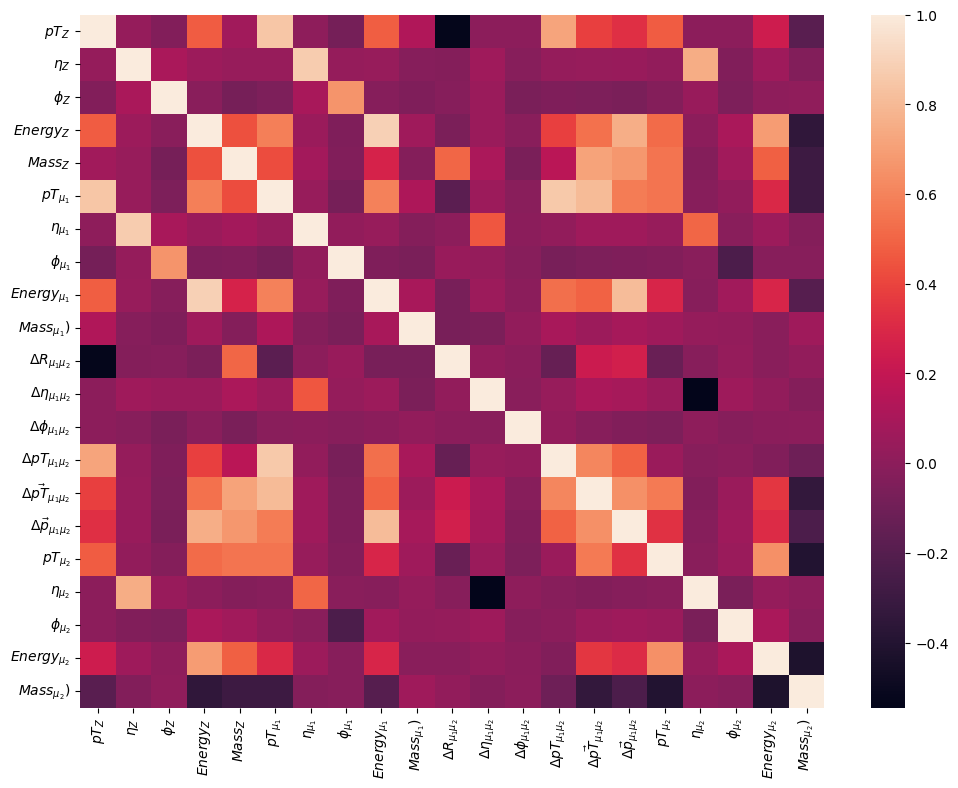

In [17]:
Correlation_Matrix = tools.dataframe_correlation(XGB_model.X, plot= True)

As we said before, it is necessary a function that analyzes the correlation between the columns and their importance at the same time to get the most important features (columns). Identifying these features will help if we need to train different models that have the same features. By this, we create the function **get_most_important_features()**. This function Analyzes the importance and correlation between all the columns and returns the ten most important features: We can also see this as a heatmap setting the parameter plot as True:

In [18]:
Features = XGB_model.get_most_important_features()

In [19]:
Features

['Mass_{Z}(GeV)',
 '#eta_{Z}',
 'pT_{Z}(GeV)',
 '#phi_{#mu_{1}}',
 '#Delta{#phi}_{#mu_{1}#mu_{2}}',
 'Energy_{#mu_{1}}(GeV)',
 '#Delta{#eta}_{#mu_{1}#mu_{2}}',
 '#phi_{#mu_{2}}',
 'Mass_{#mu_{1}}(GeV))',
 'Mass_{#mu_{2}}(GeV))']

Now, we can create another model:

In [20]:
NEW_XGB_model = XGB_Classifier(ncpu = 12,
                           cv =10, 
                           parameters = parameters,
                           signal_dictionary = Datasets_signal,
                           bkg_dictionary = Datasets_bkg,
                           balance = True )

And use the function **filter_by_features(Features)** to delete the columns that are not important to train and test the model:

In [21]:
NEW_XGB_model.filter_by_features(Features)

At this point, all attributes just have 10 columns:

In [22]:
NEW_XGB_model.trainPred

,Mass_{Z}(GeV),#eta_{Z},pT_{Z}(GeV),#phi_{#mu_{1}},#Delta{#phi}_{#mu_{1}#mu_{2}},Energy_{#mu_{1}}(GeV),#Delta{#eta}_{#mu_{1}#mu_{2}},#phi_{#mu_{2}},Mass_{#mu_{1}}(GeV)),Mass_{#mu_{2}}(GeV))
610,90.172679,-1.449701,96.652361,-2.565316,-1.233698,169.242305,-0.964731,-1.331618,0.105658,0.105658
215,143.350195,-1.910352,74.025574,-1.917515,-1.060928,264.483691,-2.700864,-0.856588,0.105658,0.105658
133,76.022351,3.545370,9.342210,-2.454402,-3.067762,66.904782,-0.855755,0.613361,0.105658,0.105658
472,80.163086,2.450586,43.552559,1.096691,-2.025995,227.021172,1.320301,3.122685,0.105658,0.105658
164,363.551025,-0.361173,16.423573,1.950734,-3.029553,180.967863,1.386140,-1.302898,0.105658,0.105658
...,...,...,...,...,...,...,...,...,...,...
412,89.904801,-1.471101,75.322592,1.552874,1.753961,99.740060,0.344031,-0.201088,0.105658,0.105658
46,89.758906,-1.207544,32.408965,2.276977,2.646949,64.112335,0.229876,-0.369971,0.105658,0.105658
487,91.262680,0.260578,20.057224,-1.185688,3.129146,55.022723,2.229746,1.968352,0.105658,0.105658
107,92.616589,1.654419,13.250763,0.017463,2.525681,35.027545,-2.790155,-2.508217,0.105658,0.105658


**3. Train Machine Learning model:**

Now, we can train the model. To do this, we can use the function **get_metrics()**. This function trains the model and returns the metrics associated with the model (train accuracy, test accuracy, and feature importance). If we want to train and print all the metrics we can set the parameter verbose as True:

In [23]:
metrics = NEW_XGB_model.get_metrics(verbose= True)

Fitting 10 folds for each of 24 candidates, totalling 240 fits
For the Gradient_Boosting model
the Best Parameters are {'learning_rate': 0.2, 'max_depth': 5, 'n_estimators': 200}
the train accuracy is 1.0
the test accuracy is 0.946969696969697
the most important variables are
                               0         1
0                  Mass_{Z}(GeV)  0.684539
1                 #phi_{#mu_{1}}  0.062120
2  #Delta{#eta}_{#mu_{1}#mu_{2}}  0.048805
3                    pT_{Z}(GeV)  0.048769
4          Energy_{#mu_{1}}(GeV)  0.048266
5  #Delta{#phi}_{#mu_{1}#mu_{2}}  0.038709
6                       #eta_{Z}  0.038265
7                 #phi_{#mu_{2}}  0.030528
8           Mass_{#mu_{1}}(GeV))  0.000000
9           Mass_{#mu_{2}}(GeV))  0.000000


**4. Save the Machine Learning model in a .joblib file:**

At this point we have our Machine learning model trained. We can save it using the function **save_model()**

In [24]:
NEW_XGB_model.save_model(file_name= 'ML_model.joblib')

The model was saved in: 
/home/pheno/2023/Semanas_22_23_24/Uniandes_Framework/tutorials/ML_model.joblib


**5. Read the Machine Learning model and plot the discriminator histograms:**

We can use the function **tools.hist_discriminator()** to read the .joblib file and plot the discriminator histograms (each signal or CSV file will have one discriminator histogram). The discriminator histograms are filled with the probabilities of binary classification problems (in this case classification in signal or background). This function has 3 important parameters, let us explain each one: path_model (path of the machine learning model that will be readed),  csv_dict  dictionary with the name of the signal and its respectively CSV file path), path_to_save: Path of the folder that we will be used to save all the histogram as .png files, its high per bin in a .dat file, and a .root file with all the histograms).

We can use the function with those parameters. However, .csv files have a lot of columns and we just used 10 for the training, so it is necessary to filter the .csv before plotting the discriminator histogram. To do this we consider a fourth parameter called Features (it is a list of the features that will be used to filter the .csv).

In this case:

In [25]:
Output = tools.hist_discriminator(path_model= 'ML_model.joblib', 
                                    best_features= Features, 
                                    path_to_save= 'Histograms',
                                    csv_dict= {'z': 'Data_z.csv', 'stop': 'Data_stop.csv', 'ttbar': 'Data_ttbar.csv', 'ww': 'Data_ww.csv'})

Info in <TCanvas::Print>: png file Histograms/histogram_ML_model_z.png has been created
Info in <TCanvas::Print>: png file Histograms/histogram_ML_model_stop.png has been created
Info in <TCanvas::Print>: png file Histograms/histogram_ML_model_ttbar.png has been created
Info in <TCanvas::Print>: png file Histograms/histogram_ML_model_ww.png has been created


In addition to this, the output is a dictionary that contains the histograms.

In [26]:
Output

{'z': <cppyy.gbl.TH1F object at 0x557f3a308a60>,
 'stop': <cppyy.gbl.TH1F object at 0x557f3a3490e0>,
 'ttbar': <cppyy.gbl.TH1F object at 0x557f3a1ef380>,
 'ww': <cppyy.gbl.TH1F object at 0x557f3a267940>}

Later we also can read the .root file that contains all the histograms. So, following the instructions explained in 2_Histograms.ipynb we can read the .root file that contains the histograms and plot the overlap:

In [27]:
Histos_to_plot = {}
for key in ['z', 'stop', 'ttbar', 'ww']:
    histo = root_analysis.read_root_file('Histograms/Histograms_ML_model.root', expected_keys=[key])[key]
    Histos_to_plot[key] = {'XGB_Output': histo}

In [28]:
Histos_to_plot

{'z': {'XGB_Output': <cppyy.gbl.TH1F object at 0x557f368520e0>},
 'stop': {'XGB_Output': <cppyy.gbl.TH1F object at 0x557f3a51a7e0>},
 'ttbar': {'XGB_Output': <cppyy.gbl.TH1F object at 0x557f3a530040>},
 'ww': {'XGB_Output': <cppyy.gbl.TH1F object at 0x557f3a32b960>}}

(<cppyy.gbl.THStack object at 0x557f3a077b60>,
 <cppyy.gbl.TLegend object at 0x557f3a757470>)

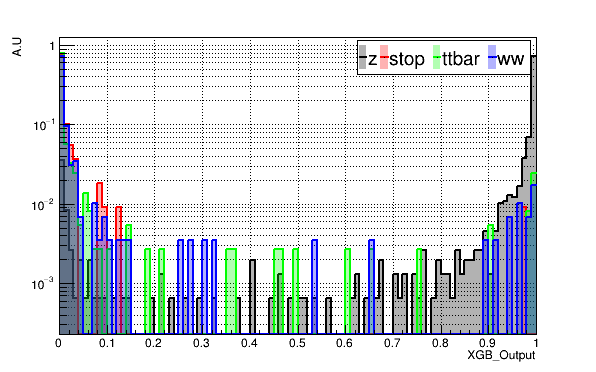

In [29]:
root_analysis.overlap_histos(kinematic_variable= 'XGB_Output', dict_histos= Histos_to_plot, log_scale= True, grid = True, alpha = 0.3)

**6. Approximate the significance using XGB_Output distributions:**

To calculate the significance using XGB_Output distributions we can use the function **power_test.approx_global_sig()**. This function has two parameters:

- sig (np.array): 1D array containing the number of signal events in each bin of the dataset.
- bkg (np.array): 1D array containing the number of background events in each bin of the dataset.

Then, in this case, we just need to read the .dat files generated by **tools.hist_discriminator()** in the Histograms folder:

In [30]:
!ls -l Histograms/*.dat

-rw-r--r--. 1 pheno pheno 2475 Jul 21 20:06 Histograms/high_per_bin_ML_model_stop.dat
-rw-r--r--. 1 pheno pheno 2475 Jul 21 20:06 Histograms/high_per_bin_ML_model_ttbar.dat
-rw-r--r--. 1 pheno pheno 2475 Jul 21 20:06 Histograms/high_per_bin_ML_model_ww.dat
-rw-r--r--. 1 pheno pheno 2475 Jul 21 20:06 Histograms/high_per_bin_ML_model_z.dat


We can read these files using numpy:

In [31]:
signal_txt = np.loadtxt('Histograms/high_per_bin_ML_model_z.dat')
for i in range(len(signal_txt)):
    if signal_txt[i] == 0: signal_txt[i] = 10e-4 #It is necessary to fill the holes

In [32]:
signal_txt

array([0.03536978, 0.00836013, 0.00257235, 0.00064309, 0.00192926,
       0.00064309, 0.00192926, 0.00064309, 0.00064309, 0.00064309,
       0.001     , 0.00064309, 0.001     , 0.00064309, 0.00064309,
       0.001     , 0.001     , 0.001     , 0.001     , 0.00064309,
       0.001     , 0.00128617, 0.001     , 0.00064309, 0.001     ,
       0.001     , 0.00064309, 0.001     , 0.001     , 0.00064309,
       0.001     , 0.001     , 0.00064309, 0.001     , 0.001     ,
       0.001     , 0.001     , 0.00064309, 0.001     , 0.001     ,
       0.00192926, 0.001     , 0.001     , 0.001     , 0.00064309,
       0.001     , 0.00128617, 0.001     , 0.00064309, 0.001     ,
       0.00064309, 0.00064309, 0.001     , 0.00064309, 0.001     ,
       0.001     , 0.00064309, 0.001     , 0.001     , 0.001     ,
       0.001     , 0.00064309, 0.00128617, 0.001     , 0.00064309,
       0.001     , 0.00064309, 0.00192926, 0.001     , 0.001     ,
       0.00128617, 0.00064309, 0.00128617, 0.001     , 0.00128

In [33]:
bkg_txt = np.loadtxt('Histograms/high_per_bin_ML_model_ttbar.dat') + np.loadtxt('Histograms/high_per_bin_ML_model_ww.dat') + np.loadtxt('Histograms/high_per_bin_ML_model_stop.dat')
for i in range(len(bkg_txt)):
    if bkg_txt[i] == 0: bkg_txt[i] = 10e-4 #It is necessary to fill the holes

In [34]:
bkg_txt

array([2.27205002e+00, 2.53285155e-01, 1.18081985e-01, 9.51844174e-02,
       1.23076350e-02, 1.35869561e-02, 8.15217383e-03, 1.30266694e-02,
       2.43356351e-02, 1.59637611e-02, 6.15381752e-03, 1.00000000e-03,
       1.25273350e-02, 3.43642617e-03, 8.87120888e-03, 1.00000000e-03,
       1.00000000e-03, 1.00000000e-03, 2.71739135e-03, 1.00000000e-03,
       1.00000000e-03, 2.71739135e-03, 1.00000000e-03, 1.00000000e-03,
       1.00000000e-03, 3.43642617e-03, 1.00000000e-03, 3.43642617e-03,
       1.00000000e-03, 1.00000000e-03, 3.43642617e-03, 1.00000000e-03,
       3.43642617e-03, 1.00000000e-03, 1.00000000e-03, 2.71739135e-03,
       2.71739135e-03, 1.00000000e-03, 1.00000000e-03, 1.00000000e-03,
       1.00000000e-03, 1.00000000e-03, 1.00000000e-03, 1.00000000e-03,
       1.00000000e-03, 2.71739135e-03, 2.71739135e-03, 1.00000000e-03,
       1.00000000e-03, 2.71739135e-03, 1.00000000e-03, 1.00000000e-03,
       1.00000000e-03, 3.43642617e-03, 1.00000000e-03, 1.00000000e-03,
      

Finally, we have the following significance:

In [35]:
power_test.approx_global_sig(sig = signal_txt, bkg = bkg_txt)

0.41861180758525096